# Energy Consumption Forecasting (kNN)

General imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

Analysis imports

In [2]:
import sklearn
from sklearn import metrics
from sklearn.neighbors import KNeighborsRegressor
from scipy.cluster.vq import kmeans, vq, whiten
from scipy.spatial.distance import cdist
import numpy as np
from datetime import datetime

## Loading and preparing energy demand data

In [3]:
# dateparser = lambda x: datetime.strptime(x, '%d.%m.%Y %H:%M')
elec_all_data = pd.read_csv("./load.csv", index_col='time', parse_dates=True, date_format='%d.%m.%Y %H:%M', usecols=['time', 'actual'])

elec_all_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8761 entries, 2022-01-01 01:00:00 to 2023-01-01 00:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   actual  8760 non-null   float64
dtypes: float64(1)
memory usage: 136.9 KB


In [4]:
elec_data = pd.DataFrame(elec_all_data).ffill()

elec_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8761 entries, 2022-01-01 01:00:00 to 2023-01-01 00:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   actual  8761 non-null   float64
dtypes: float64(1)
memory usage: 136.9 KB


<AxesSubplot:xlabel='time'>

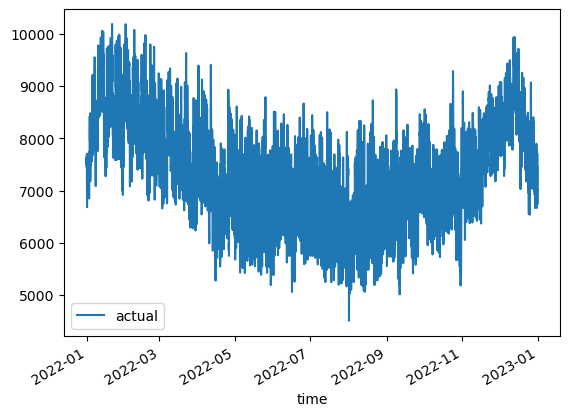

In [5]:
elec_data.plot()

In [6]:
## Loading and preparing weather data

In [7]:
weather_all_data = pd.read_csv("./weather.csv", index_col='timestamp', parse_dates=True)

In [8]:
weather_data = weather_all_data

In [9]:
weather_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8760 entries, 2022-01-01 00:00:00 to 2022-12-31 23:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   temp    8760 non-null   float64
dtypes: float64(1)
memory usage: 136.9 KB


In [10]:
weather_hourly = weather_data.resample("H").mean()
weather_hourly_nooutlier = weather_hourly[weather_hourly > -50]
weather_hourly_nooutlier_nogaps = weather_hourly_nooutlier.ffill()

In [11]:
temperature = weather_hourly_nooutlier_nogaps["temp"]

In [12]:
temperature.plot()

<AxesSubplot:xlabel='timestamp'>

## Creating Train and Test Datasets

In [13]:
training_months = [6,7,8]
test_months = [9]

training_data = elec_data[elec_data.index.month.isin(training_months)]
test_data = elec_data[elec_data.index.month.isin(test_months)]

In [14]:
training_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2208 entries, 2022-06-01 00:00:00 to 2022-08-31 23:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   actual  2208 non-null   float64
dtypes: float64(1)
memory usage: 34.5 KB


In [15]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 720 entries, 2022-09-01 00:00:00 to 2022-09-30 23:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   actual  720 non-null    float64
dtypes: float64(1)
memory usage: 11.2 KB


## Encoding Categorical Variables 

We use the pandas `.get_dummies()` function to change the temporal variables of *time of day* and *day of week* into categories that the model can use more effectively. This process is known as [enconding](https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/)

In [16]:
train_features = pd.concat([pd.get_dummies(training_data.index.hour), 
                                     pd.get_dummies(training_data.index.dayofweek), 
                                     pd.DataFrame(temperature[temperature.index.month.isin(training_months)].values)], axis=1).dropna()


In [17]:
train_features.head()

0      1      2      3      4      5      6      7      8      9   ...  \
0   True  False  False  False  False  False  False  False  False  False  ...   
1  False   True  False  False  False  False  False  False  False  False  ...   
2  False  False   True  False  False  False  False  False  False  False  ...   
3  False  False  False   True  False  False  False  False  False  False  ...   
4  False  False  False  False   True  False  False  False  False  False  ...   

      22     23     0      1     2      3      4      5      6          0   
0  False  False  False  False  True  False  False  False  False  12.670245  
1  False  False  False  False  True  False  False  False  False  11.920245  
2  False  False  False  False  True  False  False  False  False  11.080245  
3  False  False  False  False  True  False  False  False  False  11.150246  
4  False  False  False  False  True  False  False  False  False  11.060246  

[5 rows x 32 columns]

## Training a model

In [18]:
model = KNeighborsRegressor().fit(np.array(train_features), np.array(training_data.values));

In [19]:
test_features = np.array(pd.concat([pd.get_dummies(test_data.index.hour),
                                    pd.get_dummies(test_data.index.dayofweek),
                                    pd.DataFrame(temperature[temperature.index.month.isin(test_months)].values)], axis=1).dropna())

## Prediction

In [20]:
predictions = model.predict(test_features)

In [21]:
predicted_vs_actual = pd.concat([test_data, pd.DataFrame(predictions, index=test_data.index)], axis=1)

In [22]:
predicted_vs_actual.columns = ["Actual", "Predicted"]

In [23]:
predicted_vs_actual.head()

Actual  Predicted
time                                  
2022-09-01 00:00:00  6286.0     6295.4
2022-09-01 01:00:00  6233.0     6053.8
2022-09-01 02:00:00  5556.0     5800.4
2022-09-01 03:00:00  5692.0     5991.2
2022-09-01 04:00:00  6217.0     6274.2

<AxesSubplot:xlabel='time'>

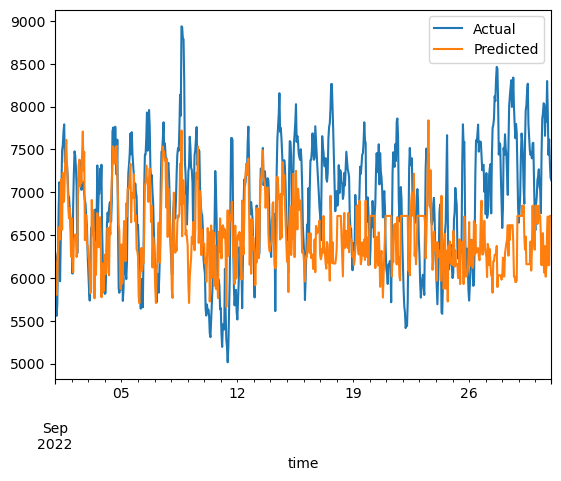

In [24]:
predicted_vs_actual.plot()

In [25]:
training_data.columns = ["Actual"]

In [26]:
predicted_vs_actual_plus_training = pd.concat([training_data, predicted_vs_actual], sort=True)

<AxesSubplot:xlabel='time'>

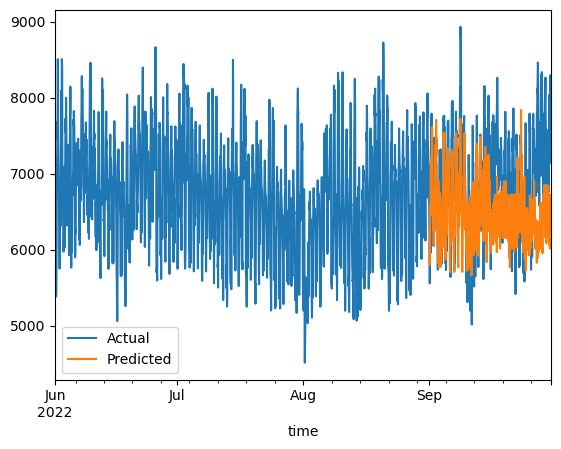

In [27]:
predicted_vs_actual_plus_training.plot()

## Evaluation metrics

In order to understand quanitatively how the model performed, we can use various evaluation metrics to understand how well the model compared to reality. 

In this situation, let's use the error metric [Mean Absolute Percentage Error (MAPE)](https://en.wikipedia.org/wiki/Mean_absolute_percentage_error) 

In [28]:
# Calculate the absolute errors
errors = abs(predicted_vs_actual['Predicted'] - predicted_vs_actual['Actual'])
# Calculate mean absolute percentage error (MAPE) and add to list
MAPE = 100 * np.mean((errors / predicted_vs_actual['Actual']))

In [29]:
MAPE

8.848783937370987